In [22]:
import numpy as np
import sklearn
import pandas as pd
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt

In [23]:
data = pd.read_csv('athletes.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


In [24]:
data.dropna()
data = data[pd.isnull(data['height']) == 0]
data = data[pd.isnull(data['weight']) == 0]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10858 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           10858 non-null  int64  
 1   name         10858 non-null  object 
 2   nationality  10858 non-null  object 
 3   sex          10858 non-null  object 
 4   dob          10858 non-null  object 
 5   height       10858 non-null  float64
 6   weight       10858 non-null  float64
 7   sport        10858 non-null  object 
 8   gold         10858 non-null  int64  
 9   silver       10858 non-null  int64  
 10  bronze       10858 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 1017.9+ KB


In [25]:
features_columns = [c for c in data.columns if c != 'sex']
X = data[features_columns]
X.head()

,id,name,nationality,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,11/26/90,1.81,71.0,cycling,0,0,0


In [26]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [27]:
X = data[['height', 'weight', 'gold', 'silver', 'bronze']]
le.fit(data['sex'])
y = pd.Series(data = le.transform(data['sex']))

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 

model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
predictions = model.predict_proba(X_test)
predictions[:,1]

array([0.61018733, 0.97346888, 0.14666797, ..., 0.95648969, 0.21192705,
       0.53842079])

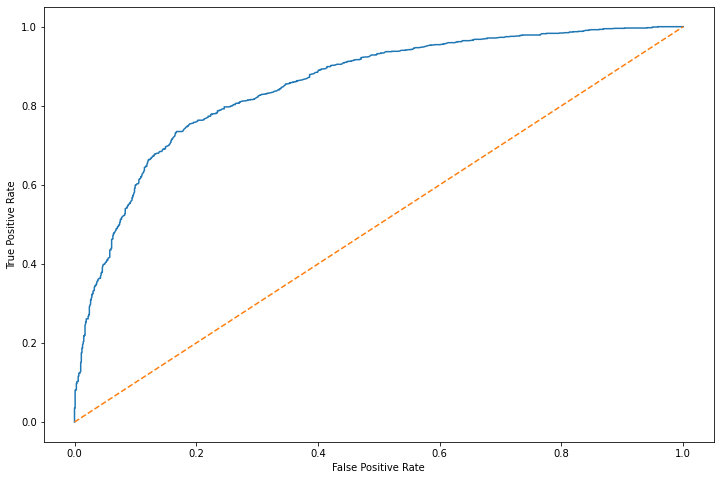

In [48]:
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve( y_test, predictions[:, 1])
fig, ax = plt.subplots()
ax.plot( fpr, tpr )
plt.plot([0,1], [0,1], linestyle = '--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
fig.set_figwidth(12)
fig.set_figheight(8)

In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, predictions[:, 1])

0.8511841826120281

In [42]:
mas = []
for thres in np.arange(0, 1.001, 0.001):
  TP, FP, TN, FN = 0, 0, 0, 0
  for pred_prob, actual in zip(predictions[:,1], y_test):
    if pred_prob > thres:
      if actual == 1: TP += 1
      else: FP += 1
    else:
      if actual == 1: FN += 1
      else: TN += 1
  mas.append([TP, FN, FP, TN])

In [43]:
TPR = []
FPR = []

for i in mas:
   TPR.append((i[0] / (i[0] + i[1])) if (i[0] + i[1]) > 0 else 0)
   FPR.append((i[2] / (i[2] + i[3])) if (i[2] + i[3]) > 0 else 0)

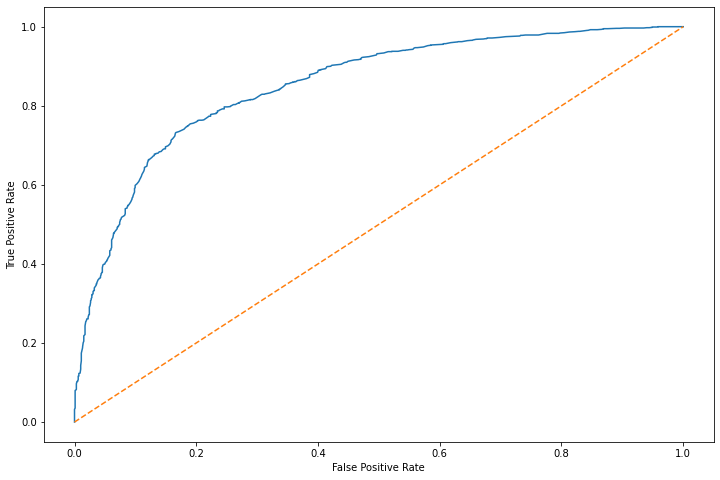

In [44]:
fig, ax = plt.subplots()
ax.plot(FPR, TPR)
ax.plot([0,1], [0,1], linestyle = '--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
fig.set_figwidth(12)
fig.set_figheight(8)

In [45]:
prec, recall = [], []
for i in mas:
  prec.append((i[0] / (i[0] + i[2])) if (i[0] + i[2]) > 0 else 0)
  recall.append((i[0] / (i[0] + i[1])) if (i[0] + i[1]) > 0 else 0)

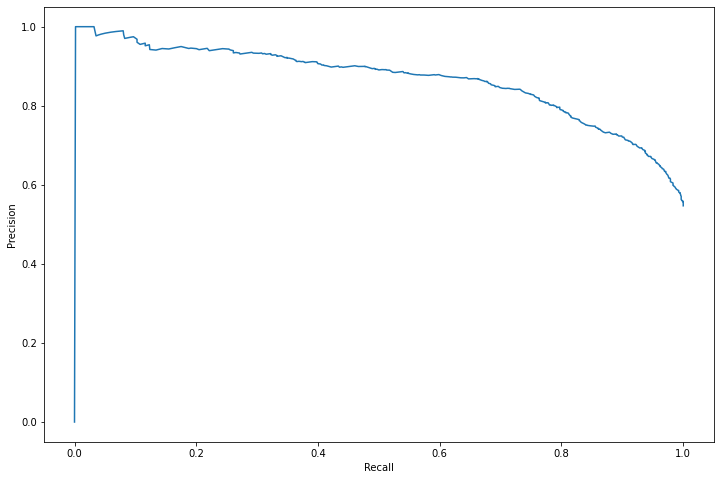

In [49]:
fig, ax = plt.subplots()
ax.plot(recall, prec)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
fig.set_figwidth(12)
fig.set_figheight(8)

In [51]:
from sklearn.metrics import auc
auc(FPR, TPR), auc(recall, prec)

(0.8511764836714023, 0.8665963186388397)

* Необходимо посмотреть на плащадь под кривой, чем она больше тем выше качество модели, также необходимо смотреть на значения, в которых пересекаются TPR и FPR.

* Для оценки вабранного датасета я использовал метрики TPR(доля реально положительных среди всех положительных) и FPR(доля ложно отрицательных среди всех отрицательных). С помощью них я строю график ROC. После нахожу площадь под кривой. Также для более детального анализа можно построить гарфик Precision-Recall и также нашел площадь под этой кривой.

* Если ROC кривая проходит ниже диагонали, это значит что необходимо поменять местами значения TPR и FPR.